In [32]:
import pandas as pd
import numpy as np
import time
import threading
import multiprocessing
from multiprocessing import Pool
import platform
import psutil
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
import heapq

In [ ]:
df = pd.read_csv('/content/train.csv')

In [ ]:
df.shape

(1458644, 11)

In [ ]:
df.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration'],
      dtype='object')

In [ ]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [ ]:
df['trip_duration'].head(10)

,trip_duration
0,455
1,663
2,2124
3,429
4,435
5,443
6,341
7,1551
8,255
9,1225


In [ ]:
df['trip_duration'].isnull()

,trip_duration
0,False
1,False
2,False
3,False
4,False
...,...
1458639,False
1458640,False
1458641,False
1458642,False


In [ ]:
def get_system_specs():
    specs = {
        'Processor': platform.processor() or platform.machine(),
        'CPU Cores (Physical)': psutil.cpu_count(logical=False),
        'CPU Cores (Logical)': psutil.cpu_count(logical=True),
        'RAM (GB)': round(psutil.virtual_memory().total / (1024**3), 2),
        'Platform': platform.system(),
        'Python Version': platform.python_version()
    }
    return specs

specs = get_system_specs()
print("MACHINE SPECIFICATIONS:")
for key, value in specs.items():
    print(f"{key}: {value}")

MACHINE SPECIFICATIONS:
Processor: x86_64
CPU Cores (Physical): 1
CPU Cores (Logical): 2
RAM (GB): 12.67
Platform: Linux
Python Version: 3.11.13


In [ ]:
trip_duration = df['trip_duration']
df25 = trip_duration.sample(frac=0.25, random_state=42).reset_index(drop=True)
df50 = trip_duration.sample(frac=0.50, random_state=42).reset_index(drop=True)
df75 = trip_duration.sample(frac=0.75, random_state=42).reset_index(drop=True)
df100 = trip_duration.sample(frac=1.00, random_state=42).reset_index(drop=True)

In [ ]:
def sort_trip_duration(arr):
    return np.sort(arr)
def filter_trip_duration(arr, threshold=1500):
    return arr[arr > threshold]

In [ ]:
# Calculate parallel fraction using Amdahl's Law
#S = 1 / ((1 - f) + f / n)
def amdahl_fraction(speedup, n_workers):
    if speedup <= 0 or n_workers <= 1:
        return 0.0
    return (1 - 1/speedup) / (1 - 1/n_workers)

SORTING LOOP FOR 3 PROCESSES

In [ ]:
# Chunk array
def chunk_array(arr, n_chunks):
    return np.array_split(arr, n_chunks)

# Sorting chunk
def sort_chunk(chunk):
    return sort_trip_duration(chunk)

# Split
splits = {
    "25%": df25,
    "50%": df50,
    "75%": df75,
    "100%": df100
}

results_sort = []

for label, data in splits.items():
    data_np = data.to_numpy()

    seq_times, thread_times, mp_times = [], [], []

    for _ in range(5):
        # Sequential
        start = time.perf_counter()
        _ = sort_trip_duration(data_np)
        end = time.perf_counter()
        seq_times.append(end - start)

        # Threading
        chunks = chunk_array(data_np, 4)
        start = time.perf_counter()
        with ThreadPoolExecutor(max_workers=4) as executor:
            sorted_chunks = list(executor.map(sort_chunk, chunks))
        sorted_thread = np.fromiter(heapq.merge(*sorted_chunks), dtype=data_np.dtype)
        end = time.perf_counter()
        thread_times.append(end - start)

        # Multiprocessing
        chunks = chunk_array(data_np, 4)
        start = time.perf_counter()
        with ProcessPoolExecutor(max_workers=4) as executor:
            sorted_chunks = list(executor.map(sort_chunk, chunks))
        sorted_mp = np.fromiter(heapq.merge(*sorted_chunks), dtype=data_np.dtype)
        end = time.perf_counter()
        mp_times.append(end - start)

    # Calculate the mean and standard deviation
    seq_mean, seq_std = np.mean(seq_times), np.std(seq_times)
    thread_mean, thread_std = np.mean(thread_times), np.std(thread_times)
    mp_mean, mp_std = np.mean(mp_times), np.std(mp_times)

    # Calculate the speedups
    thread_speedup = seq_mean / thread_mean if thread_mean > 0 else 0
    mp_speedup = seq_mean / mp_mean if mp_mean > 0 else 0

    results_sort.append([
        label, len(data_np),
        f"{seq_mean:.4f} ± {seq_std:.4f}",
        f"{thread_mean:.4f} ± {thread_std:.4f}",
        f"{mp_mean:.4f} ± {mp_std:.4f}",
        f"{thread_speedup:.2f}x", f"{mp_speedup:.2f}x"
    ])

df_results_sort = pd.DataFrame(results_sort, columns=[
    "Data Split", "Data Size", "Sequential (s)", "Threading (s)", "Multiprocessing (s)",
    "Threading Speedup", "MP Speedup"
])

print("=== Sorting Performance ===")
print(df_results_sort)

=== Sorting Performance ===
  Data Split  Data Size   Sequential (s)    Threading (s) Multiprocessing (s)  \
0        25%     364661  0.0215 ± 0.0071  0.6772 ± 0.2147     0.8080 ± 0.2844   
1        50%     729322  0.0117 ± 0.0016  0.3723 ± 0.0728     0.5231 ± 0.0372   
2        75%    1093983  0.0196 ± 0.0051  0.6244 ± 0.1412     0.7717 ± 0.1959   
3       100%    1458644  0.0212 ± 0.0005  0.6205 ± 0.0086     0.8389 ± 0.0120   

  Threading Speedup MP Speedup  
0             0.03x      0.03x  
1             0.03x      0.02x  
2             0.03x      0.03x  
3             0.03x      0.03x  


In [33]:
print("\n=== Estimated Parallel Fraction (Amdahl) ===")
for idx, row in df_results_sort.iterrows():
    thread_speedup = float(row["Threading Speedup"].replace("x", ""))
    mp_speedup = float(row["MP Speedup"].replace("x", ""))
    f_thread = amdahl_fraction(thread_speedup, 4)
    f_mp = amdahl_fraction(mp_speedup, 4)
    print(f"{row['Data Split']}: Thread f={f_thread:.3f}, MP f={f_mp:.3f}")


=== Estimated Parallel Fraction (Amdahl) ===
25%: Thread f=-43.111, MP f=-43.111
50%: Thread f=-43.111, MP f=-65.333
75%: Thread f=-43.111, MP f=-43.111
100%: Thread f=-43.111, MP f=-43.111


FILTERING LOOP FOR 3 PROCESSES

In [ ]:
# Filtering the chunk
def filter_chunk(chunk):
    return filter_trip_duration(chunk, threshold=1500)

results_filter = []

for label, data in splits.items():
    data_np = data.to_numpy()

    seq_times, thread_times, mp_times = [], [], []

    for _ in range(5):
        # Sequential
        start = time.perf_counter()
        _ = filter_trip_duration(data_np, threshold=1500)
        end = time.perf_counter()
        seq_times.append(end - start)

        # Threading
        chunks = chunk_array(data_np, 4)
        start = time.perf_counter()
        with ThreadPoolExecutor(max_workers=4) as executor:
            filtered_chunks = list(executor.map(filter_chunk, chunks))
        filtered_thread = np.concatenate(filtered_chunks)
        end = time.perf_counter()
        thread_times.append(end - start)

        # Multiprocessing
        chunks = chunk_array(data_np, 4)
        start = time.perf_counter()
        with ProcessPoolExecutor(max_workers=4) as executor:
            filtered_chunks = list(executor.map(filter_chunk, chunks))
        filtered_mp = np.concatenate(filtered_chunks)
        end = time.perf_counter()
        mp_times.append(end - start)

    # Calculate the mean and the standard deviation
    seq_mean, seq_std = np.mean(seq_times), np.std(seq_times)
    thread_mean, thread_std = np.mean(thread_times), np.std(thread_times)
    mp_mean, mp_std = np.mean(mp_times), np.std(mp_times)

    # Calculate the speedups
    thread_speedup = seq_mean / thread_mean if thread_mean > 0 else 0
    mp_speedup = seq_mean / mp_mean if mp_mean > 0 else 0

    results_filter.append([
        label, len(data_np),
        f"{seq_mean:.4f} ± {seq_std:.4f}",
        f"{thread_mean:.4f} ± {thread_std:.4f}",
        f"{mp_mean:.4f} ± {mp_std:.4f}",
        f"{thread_speedup:.2f}x", f"{mp_speedup:.2f}x"
    ])

df_results_filter = pd.DataFrame(results_filter, columns=[
    "Data Split", "Data Size", "Sequential (s)", "Threading (s)", "Multiprocessing (s)",
    "Threading Speedup", "MP Speedup"
])

print("\n=== Filtering Performance ===")
print(df_results_filter)


=== Filtering Performance ===
  Data Split  Data Size   Sequential (s)    Threading (s) Multiprocessing (s)  \
0        25%     364661  0.0025 ± 0.0003  0.0028 ± 0.0005     0.1557 ± 0.0333   
1        50%     729322  0.0066 ± 0.0006  0.0070 ± 0.0010     0.2518 ± 0.0107   
2        75%    1093983  0.0084 ± 0.0006  0.0079 ± 0.0017     0.2585 ± 0.0128   
3       100%    1458644  0.0093 ± 0.0005  0.0076 ± 0.0005     0.1887 ± 0.0066   

  Threading Speedup MP Speedup  
0             0.91x      0.02x  
1             0.94x      0.03x  
2             1.06x      0.03x  
3             1.23x      0.05x  


In [34]:
# Calculate the parallel fraction for Threading and Multiprocessing in Filtering
print("\n=== Estimated Parallel Fraction (Amdahl) - Filtering ===")
for idx, row in df_results_filter.iterrows():
    thread_speedup = float(row["Threading Speedup"].replace("x", ""))
    mp_speedup = float(row["MP Speedup"].replace("x", ""))
    f_thread = amdahl_fraction(thread_speedup, 4)
    f_mp = amdahl_fraction(mp_speedup, 4)
    print(f"{row['Data Split']}: Thread f={f_thread:.3f}, MP f={f_mp:.3f}")


=== Estimated Parallel Fraction (Amdahl) - Filtering ===
25%: Thread f=-0.132, MP f=-65.333
50%: Thread f=-0.085, MP f=-43.111
75%: Thread f=0.075, MP f=-43.111
100%: Thread f=0.249, MP f=-25.333


COMBINED (SORTING + FILTERING) LOOP FOR 3 PROCESSES

In [ ]:
def filter_and_sort_trip_duration(arr, threshold=1500):
    filtered = filter_trip_duration(arr, threshold=threshold)
    return sort_trip_duration(filtered)

def filter_and_sort_chunk(chunk):
    return filter_and_sort_trip_duration(chunk, threshold=1500)

results_filter_sort = []

for label, data in splits.items():
    data_np = data.to_numpy()

    seq_times, thread_times, mp_times = [], [], []

    for _ in range(5):
        # Sequential
        start = time.perf_counter()
        _ = filter_and_sort_trip_duration(data_np, threshold=1500)
        end = time.perf_counter()
        seq_times.append(end - start)

        # Threading
        chunks = chunk_array(data_np, 4)
        start = time.perf_counter()
        with ThreadPoolExecutor(max_workers=4) as executor:
            processed_chunks = list(executor.map(filter_and_sort_chunk, chunks))
        merged_thread = np.fromiter(heapq.merge(*processed_chunks), dtype=data_np.dtype)
        end = time.perf_counter()
        thread_times.append(end - start)

        # Multiprocessing
        chunks = chunk_array(data_np, 4)
        start = time.perf_counter()
        with ProcessPoolExecutor(max_workers=4) as executor:
            processed_chunks = list(executor.map(filter_and_sort_chunk, chunks))
        merged_mp = np.fromiter(heapq.merge(*processed_chunks), dtype=data_np.dtype)
        end = time.perf_counter()
        mp_times.append(end - start)

    # Calculate mean and std
    seq_mean, seq_std = np.mean(seq_times), np.std(seq_times)
    thread_mean, thread_std = np.mean(thread_times), np.std(thread_times)
    mp_mean, mp_std = np.mean(mp_times), np.std(mp_times)

    # Calculate speedups
    thread_speedup = seq_mean / thread_mean if thread_mean > 0 else 0
    mp_speedup = seq_mean / mp_mean if mp_mean > 0 else 0

    results_filter_sort.append([
        label, len(data_np),
        f"{seq_mean:.4f} ± {seq_std:.4f}",
        f"{thread_mean:.4f} ± {thread_std:.4f}",
        f"{mp_mean:.4f} ± {mp_std:.4f}",
        f"{thread_speedup:.2f}x", f"{mp_speedup:.2f}x"
    ])

df_results_filter_sort = pd.DataFrame(results_filter_sort, columns=[
    "Data Split", "Data Size", "Sequential (s)", "Threading (s)", "Multiprocessing (s)",
    "Threading Speedup", "MP Speedup"
])

print("\nFiltering + Sorting Performance")
print(df_results_filter_sort)


Filtering + Sorting Performance
  Data Split  Data Size   Sequential (s)    Threading (s) Multiprocessing (s)  \
0        25%     364661  0.0077 ± 0.0044  0.0470 ± 0.0099     0.2789 ± 0.0162   
1        50%     729322  0.0080 ± 0.0014  0.0634 ± 0.0157     0.2740 ± 0.0572   
2        75%    1093983  0.0095 ± 0.0013  0.0655 ± 0.0017     0.2513 ± 0.0089   
3       100%    1458644  0.0123 ± 0.0013  0.0842 ± 0.0018     0.2792 ± 0.0071   

  Threading Speedup MP Speedup  
0             0.16x      0.03x  
1             0.13x      0.03x  
2             0.14x      0.04x  
3             0.15x      0.04x  


SORTING LINE GRAPH

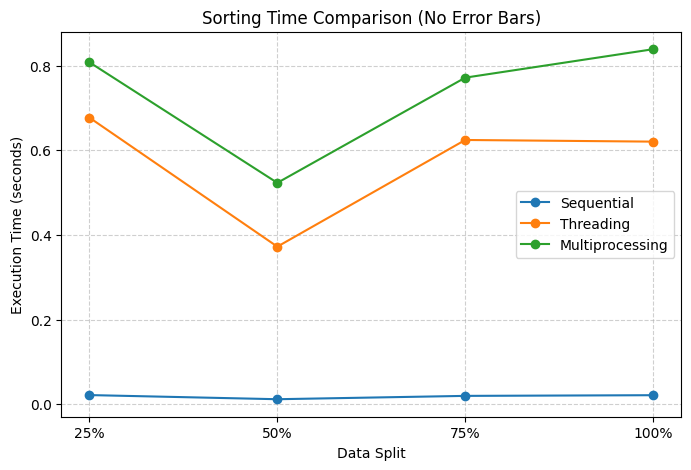

In [ ]:
labels = df_results_sort["Data Split"]
f_thread_sort = []
f_mp_sort = []

seq_time_sort = [float(val.split("±")[0]) for val in df_results_sort["Sequential (s)"]]
thread_time_sort = [float(val.split("±")[0]) for val in df_results_sort["Threading (s)"]]
mp_time_sort = [float(val.split("±")[0]) for val in df_results_sort["Multiprocessing (s)"]]

plt.figure(figsize=(8,5))
plt.plot(labels, seq_time_sort, marker='o', label="Sequential")
plt.plot(labels, thread_time_sort, marker='o', label="Threading")
plt.plot(labels, mp_time_sort, marker='o', label="Multiprocessing")
plt.title("Sorting Time Comparison (No Error Bars)")
plt.xlabel("Data Split")
plt.ylabel("Execution Time (seconds)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

SORTING GRAPH WITH ERROR BARS

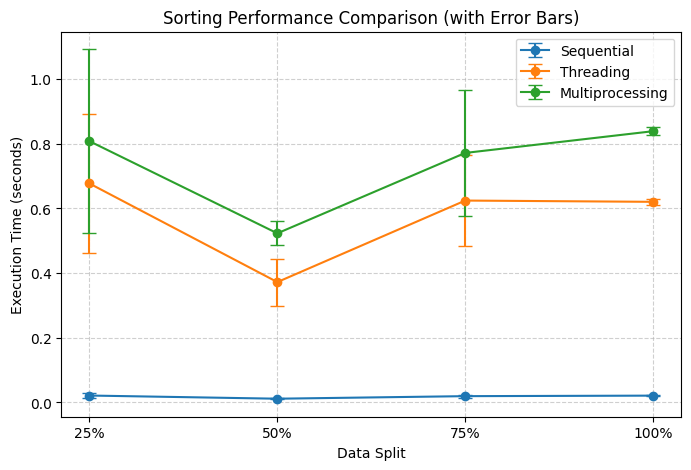

In [ ]:
def extract_mean_std(val):
    mean, std = val.split("±")
    return float(mean.strip()), float(std.strip())

df_sort_plot = df_results_sort.copy()
seq_mean, seq_std = zip(*df_sort_plot["Sequential (s)"].apply(extract_mean_std))
thread_mean, thread_std = zip(*df_sort_plot["Threading (s)"].apply(extract_mean_std))
mp_mean, mp_std = zip(*df_sort_plot["Multiprocessing (s)"].apply(extract_mean_std))

plt.figure(figsize=(8,5))
plt.errorbar(df_sort_plot["Data Split"], seq_mean, yerr=seq_std, marker='o', capsize=5, label="Sequential")
plt.errorbar(df_sort_plot["Data Split"], thread_mean, yerr=thread_std, marker='o', capsize=5, label="Threading")
plt.errorbar(df_sort_plot["Data Split"], mp_mean, yerr=mp_std, marker='o', capsize=5, label="Multiprocessing")

plt.title("Sorting Performance Comparison (with Error Bars)")
plt.xlabel("Data Split")
plt.ylabel("Execution Time (seconds)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

AMDAHL LAW COMPARISON SORTING GRAPH

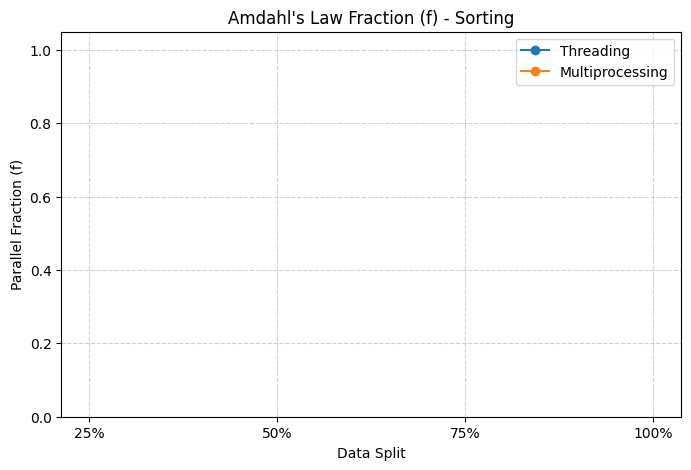

In [ ]:
labels = df_results_sort["Data Split"]
f_thread_sort = []
f_mp_sort = []

for idx, row in df_results_sort.iterrows():
    thread_speedup = float(row["Threading Speedup"].replace("x", ""))
    mp_speedup = float(row["MP Speedup"].replace("x", ""))
    f_thread_sort.append(amdahl_fraction(thread_speedup, 4))
    f_mp_sort.append(amdahl_fraction(mp_speedup, 4))

plt.figure(figsize=(8,5))
plt.plot(labels, f_thread_sort, marker='o', label="Threading")
plt.plot(labels, f_mp_sort, marker='o', label="Multiprocessing")
plt.title("Amdahl's Law Fraction (f) - Sorting")
plt.xlabel("Data Split")
plt.ylabel("Parallel Fraction (f)")
plt.ylim(0, 1.05)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

FILTERING LINE GRAPH

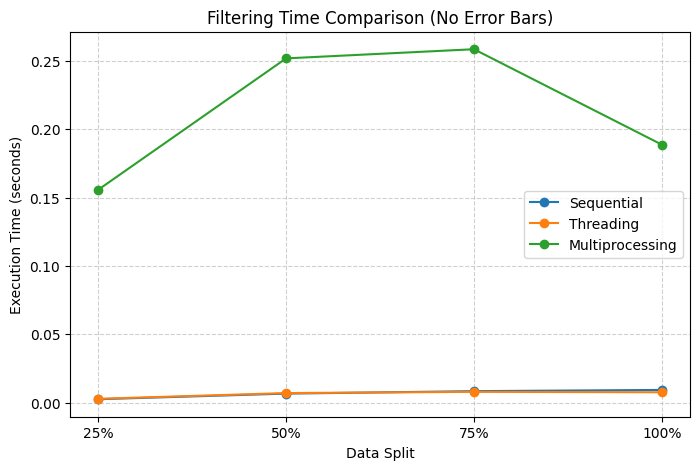

In [ ]:
seq_time_filter = [float(val.split("±")[0]) for val in df_results_filter["Sequential (s)"]]
thread_time_filter = [float(val.split("±")[0]) for val in df_results_filter["Threading (s)"]]
mp_time_filter = [float(val.split("±")[0]) for val in df_results_filter["Multiprocessing (s)"]]

plt.figure(figsize=(8,5))
plt.plot(labels, seq_time_filter, marker='o', label="Sequential")
plt.plot(labels, thread_time_filter, marker='o', label="Threading")
plt.plot(labels, mp_time_filter, marker='o', label="Multiprocessing")
plt.title("Filtering Time Comparison (No Error Bars)")
plt.xlabel("Data Split")
plt.ylabel("Execution Time (seconds)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

FILTERING GRAPH WITH ERROR BARS

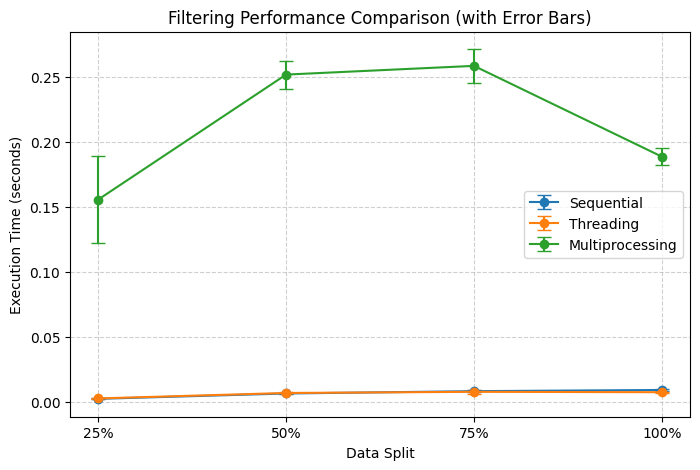

In [ ]:
df_filter_plot = df_results_filter.copy()
seq_mean, seq_std = zip(*df_filter_plot["Sequential (s)"].apply(extract_mean_std))
thread_mean, thread_std = zip(*df_filter_plot["Threading (s)"].apply(extract_mean_std))
mp_mean, mp_std = zip(*df_filter_plot["Multiprocessing (s)"].apply(extract_mean_std))

plt.figure(figsize=(8,5))
plt.errorbar(df_filter_plot["Data Split"], seq_mean, yerr=seq_std, marker='o', capsize=5, label="Sequential")
plt.errorbar(df_filter_plot["Data Split"], thread_mean, yerr=thread_std, marker='o', capsize=5, label="Threading")
plt.errorbar(df_filter_plot["Data Split"], mp_mean, yerr=mp_std, marker='o', capsize=5, label="Multiprocessing")

plt.title("Filtering Performance Comparison (with Error Bars)")
plt.xlabel("Data Split")
plt.ylabel("Execution Time (seconds)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

AMDAHL LAW COMPARISON GRAPH FILTERING

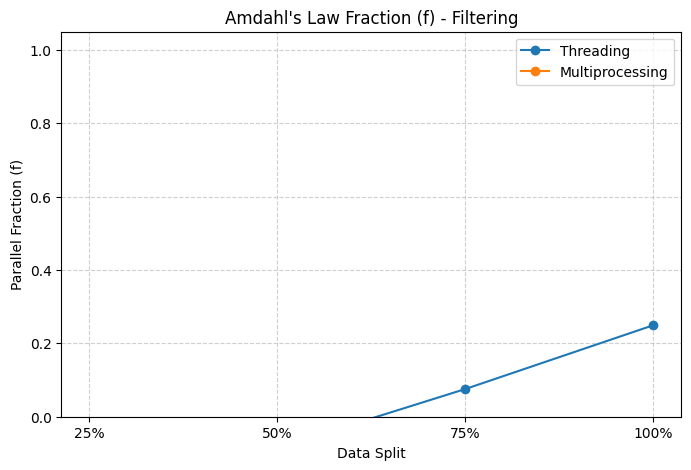

In [ ]:
f_thread_filter = []
f_mp_filter = []

for idx, row in df_results_filter.iterrows():
    thread_speedup = float(row["Threading Speedup"].replace("x", ""))
    mp_speedup = float(row["MP Speedup"].replace("x", ""))
    f_thread_filter.append(amdahl_fraction(thread_speedup, 4))
    f_mp_filter.append(amdahl_fraction(mp_speedup, 4))

plt.figure(figsize=(8,5))
plt.plot(labels, f_thread_filter, marker='o', label="Threading")
plt.plot(labels, f_mp_filter, marker='o', label="Multiprocessing")
plt.title("Amdahl's Law Fraction (f) - Filtering")
plt.xlabel("Data Split")
plt.ylabel("Parallel Fraction (f)")
plt.ylim(0, 1.05)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

COMBINED (SORTING + FILTERING) GRAPH (no error bars)

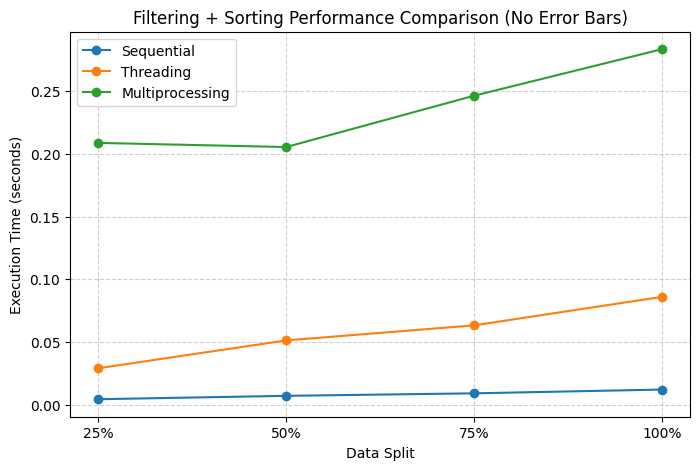

In [ ]:
def extract_mean_std(val):
    mean, std = val.split("±")
    return float(mean.strip()), float(std.strip())

seq_mean, seq_std = zip(*df_results_filter_sort["Sequential (s)"].apply(extract_mean_std))
thread_mean, thread_std = zip(*df_results_filter_sort["Threading (s)"].apply(extract_mean_std))
mp_mean, mp_std = zip(*df_results_filter_sort["Multiprocessing (s)"].apply(extract_mean_std))

plt.figure(figsize=(8,5))
plt.plot(df_results_filter_sort["Data Split"], seq_mean, marker='o', label="Sequential")
plt.plot(df_results_filter_sort["Data Split"], thread_mean, marker='o', label="Threading")
plt.plot(df_results_filter_sort["Data Split"], mp_mean, marker='o', label="Multiprocessing")

plt.title("Filtering + Sorting Performance Comparison (No Error Bars)")
plt.xlabel("Data Split")
plt.ylabel("Execution Time (seconds)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

COMBINED (SORTING + FILTERING) GRAPH (with error bars)

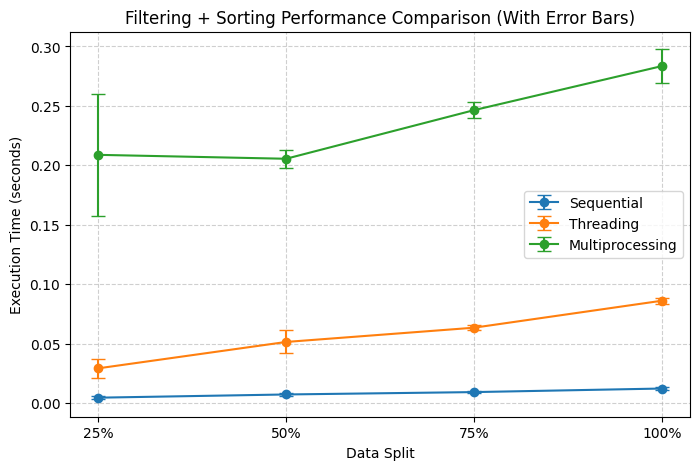

In [ ]:
plt.figure(figsize=(8,5))
plt.errorbar(df_results_filter_sort["Data Split"], seq_mean, yerr=seq_std, marker='o', capsize=5, label="Sequential")
plt.errorbar(df_results_filter_sort["Data Split"], thread_mean, yerr=thread_std, marker='o', capsize=5, label="Threading")
plt.errorbar(df_results_filter_sort["Data Split"], mp_mean, yerr=mp_std, marker='o', capsize=5, label="Multiprocessing")

plt.title("Filtering + Sorting Performance Comparison (With Error Bars)")
plt.xlabel("Data Split")
plt.ylabel("Execution Time (seconds)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()